In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [2]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [3]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Rainfall/Srimangal.csv')
#the daily dataset
print(df.shape)
df.head()

(21093, 2)


,DATE,Rainfall(mm)
0,4/1/1961,0.0
1,4/2/1961,0.0
2,4/3/1961,0.3
3,4/4/1961,0.0
4,4/5/1961,0.0


In [4]:
#checking types
df.dtypes

DATE             object
Rainfall(mm)    float64
dtype: object

Data Preprocessing
---------

In [5]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

            DATE  Rainfall(mm)
0       4/1/1961           0.0
1       4/2/1961           0.0
2       4/3/1961           0.3
3       4/4/1961           0.0
4       4/5/1961           0.0
...          ...           ...
21088  4/26/2019           0.0
21089  4/27/2019           0.0
21090  4/28/2019           1.0
21091  4/29/2019           9.0
21092  4/30/2019           0.0

[21093 rows x 2 columns]


In [6]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [7]:
df.head()

,DATE,Rainfall(mm)
0,4/1/1961,0.0
1,4/2/1961,0.0
2,4/3/1961,0.3
3,4/4/1961,0.0
4,4/5/1961,0.0


In [8]:
df.tail()

,DATE,Rainfall(mm)
21088,4/26/2019,0.0
21089,4/27/2019,0.0
21090,4/28/2019,1.0
21091,4/29/2019,9.0
21092,4/30/2019,0.0


In [9]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
df_pr.sort_values('DATE', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('DATE', inplace=True)
df_pr.head()

,Rainfall(mm)
DATE,
1/1/1962,0.0
1/1/1963,0.0
1/1/1964,0.0
1/1/1965,0.0
1/1/1966,0.0


In [10]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Srimangal_monthly.csv")

(697, 1)


In [11]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1961-04-30 00:00:00
End Date: 2019-04-30 00:00:00
Total month: 697
Total year: 58


Data Visulalization
----------

About Data

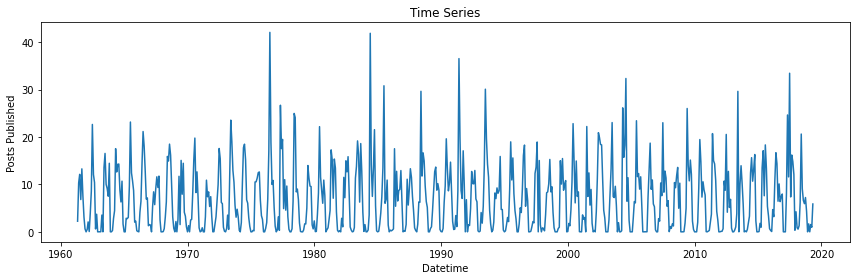

In [12]:
# 7.Plotting the time series
monthly['Rainfall(mm)'] = monthly['Rainfall(mm)'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(585, 1), Validation=(112, 1)


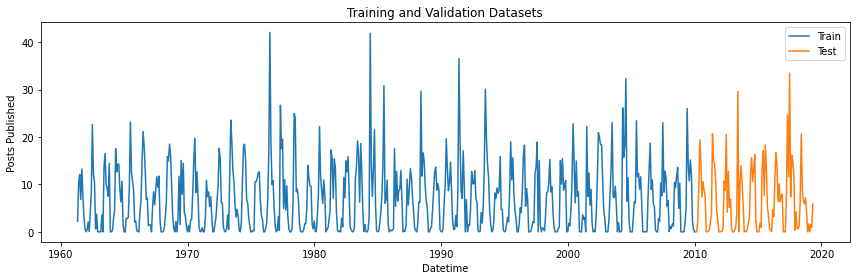

In [13]:
train = monthly.loc[:'2009-12-31']
valid = monthly.loc['2010-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [14]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [15]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

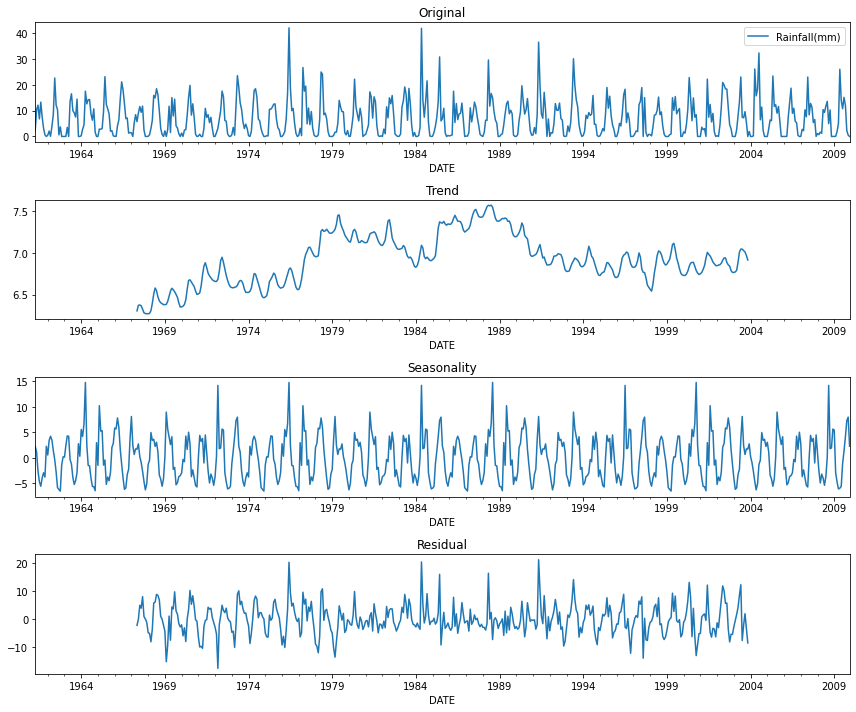

In [16]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10)) 
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [17]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

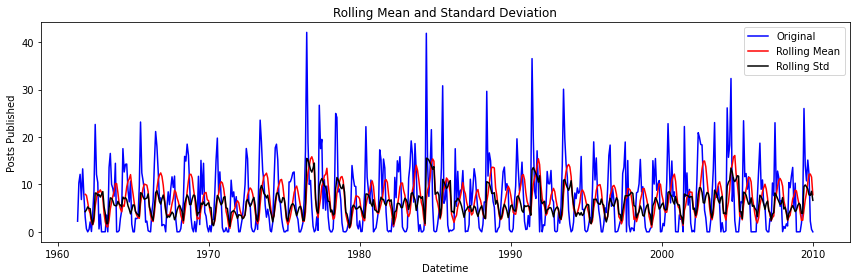

Results of Dickey-Fuller Test:
Test Statistic                -6.789301e+00
P-Value                        2.387258e-09
#Lags Used                     1.800000e+01
Number of Observations Used    5.660000e+02
Critical Value (1%)           -3.441956e+00
Critical Value (5%)           -2.866660e+00
Critical Value (10%)          -2.569497e+00
dtype: float64


In [18]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL 

In [19]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [20]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Rainfall(mm)   No. Observations:                  585
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -1773.853
Date:                Sun, 06 Nov 2022   AIC                           3565.706
Time:                        17:55:01   BIC                           3605.035
Sample:                    04-30-1961   HQIC                          3581.034
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2581      0.039      6.620      0.000       0.182       0.335
ar.L2          0.0343      0.045      0.757      0.449      -0.055       0.123
ar.L3         -0.0461      0.042     -1.110      0.2

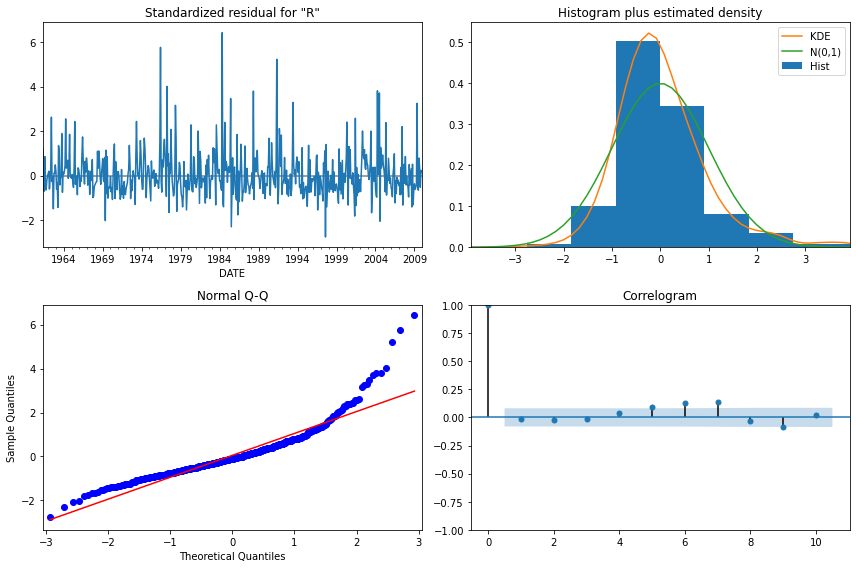

In [21]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

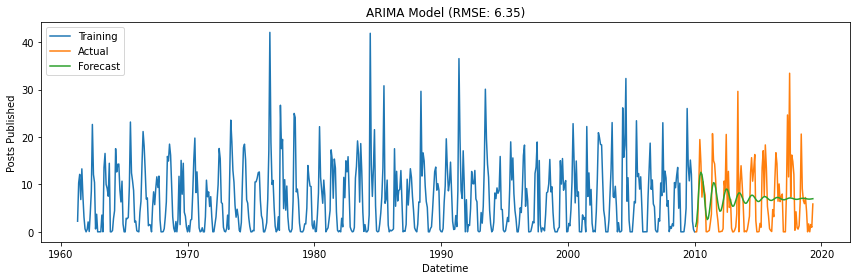

In [22]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [23]:
#Values of ARIMA prediction
print(forecast_arima)

2010-01-31     1.145921
2010-02-28     2.122963
2010-03-31     4.912959
2010-04-30     8.871979
2010-05-31    11.760984
                ...    
2018-12-31     6.897319
2019-01-31     6.895974
2019-02-28     6.914563
2019-03-31     6.946703
2019-04-30     6.983038
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [24]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  6.346425836434516


---------------------

SARIMAX MODEL

In [25]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [26]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                       Rainfall(mm)   No. Observations:                  585
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood               -1668.378
Date:                            Sun, 06 Nov 2022   AIC                           3370.757
Time:                                    17:57:20   BIC                           3444.692
Sample:                                04-30-1961   HQIC                          3399.600
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0498      0.039      1.273      0.203      -0.027       0.126
ar.L2          0.0161      0.053   

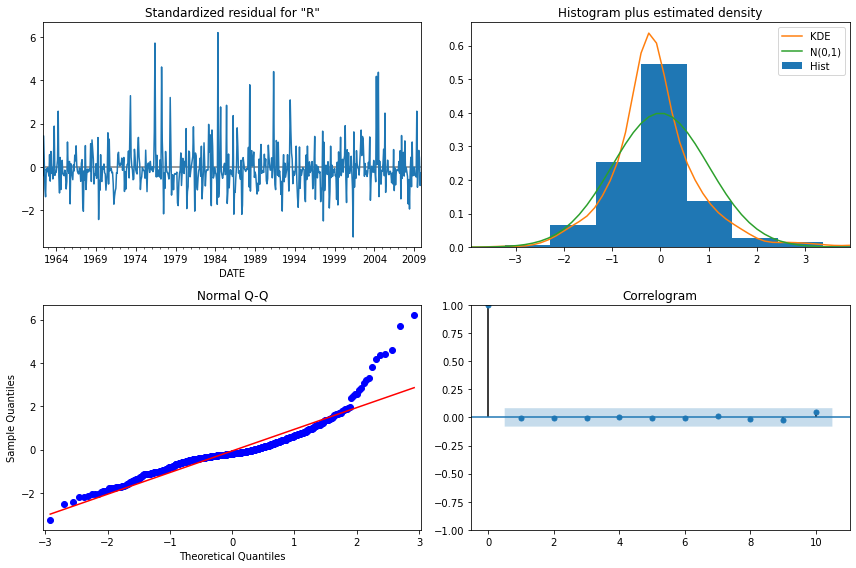

In [27]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

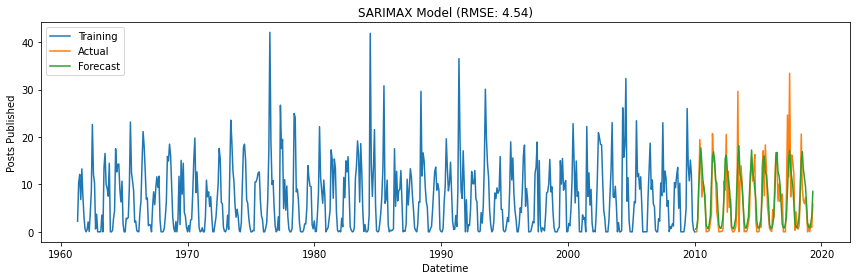

In [28]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [29]:
#Value of SARIMA prediction
print(forecast_sarimax)

2010-01-31     0.586140
2010-02-28     0.854656
2010-03-31     2.668890
2010-04-30     9.760033
2010-05-31    13.943858
                ...    
2018-12-31     0.979878
2019-01-31     0.850436
2019-02-28     1.730048
2019-03-31     3.343978
2019-04-30     8.514502
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [30]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  4.539316446274864


-----------------------

PROPHET

In [31]:
#Reading monthly data 
df= pd.read_csv('Srimangal_monthly.csv')

In [32]:
#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1961-04-30,2.236667
1,1961-05-31,10.306452
2,1961-06-30,12.120000
3,1961-07-31,6.803226
4,1961-08-31,13.274194


In [33]:
#prophet model Implement
prophet_model = Prophet()

In [34]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjotmg8k_/93wt0506.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjotmg8k_/nn0no19d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28322', 'data', 'file=/tmp/tmpjotmg8k_/93wt0506.json', 'init=/tmp/tmpjotmg8k_/nn0no19d.json', 'output', 'file=/tmp/tmpjotmg8k_/prophet_modeldvvl57cc/prophet_model-20221106175722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [35]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 6, freq='M')
print(prophet_forecast_date)

            ds
0   1961-04-30
1   1961-05-31
2   1961-06-30
3   1961-07-31
4   1961-08-31
..         ...
764 2024-12-31
765 2025-01-31
766 2025-02-28
767 2025-03-31
768 2025-04-30

[769 rows x 1 columns]


In [36]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1961-04-30,6.305486,1.974746,13.429403,6.305486,6.305486,1.245764,1.245764,1.245764,1.245764,1.245764,1.245764,0.0,0.0,0.0,7.551251
1,1961-05-31,6.307872,9.630360,20.156999,6.307872,6.307872,8.398763,8.398763,8.398763,8.398763,8.398763,8.398763,0.0,0.0,0.0,14.706635
2,1961-06-30,6.310180,10.242832,20.932734,6.310180,6.310180,9.557516,9.557516,9.557516,9.557516,9.557516,9.557516,0.0,0.0,0.0,15.867697
3,1961-07-31,6.312565,5.910960,16.634593,6.312565,6.312565,4.963834,4.963834,4.963834,4.963834,4.963834,4.963834,0.0,0.0,0.0,11.276399
4,1961-08-31,6.314951,4.922134,15.716986,6.314951,6.314951,3.969314,3.969314,3.969314,3.969314,3.969314,3.969314,0.0,0.0,0.0,10.284265


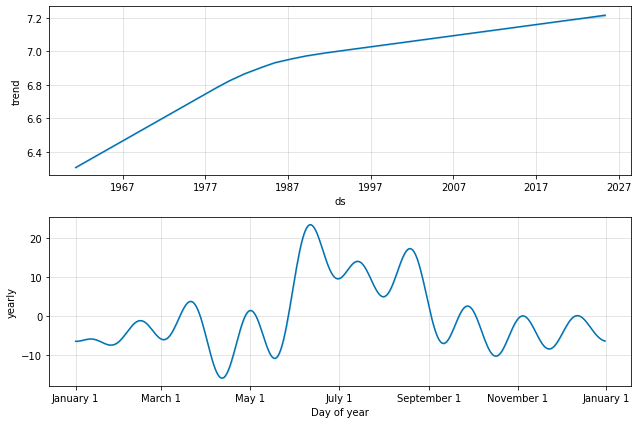

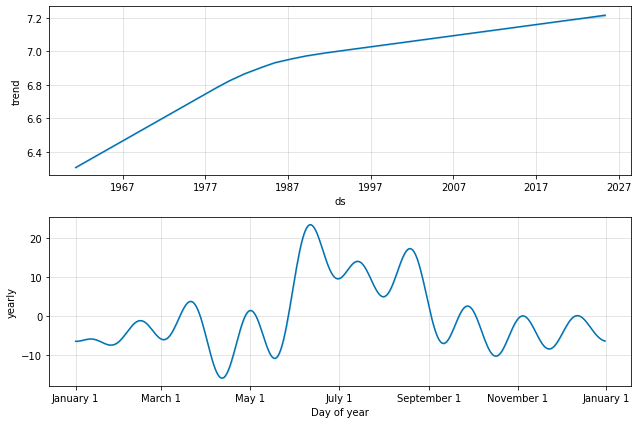

In [37]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [38]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe 
fd=forecast_prophet_data.set_index('ds')
print(fd)

                 yhat
ds                   
1961-04-30   7.551251
1961-05-31  14.706635
1961-06-30  15.867697
1961-07-31  11.276399
1961-08-31  10.284265
...               ...
2024-12-31   0.766158
2025-01-31   0.705608
2025-02-28   1.455359
2025-03-31   2.799543
2025-04-30   8.462515

[769 rows x 1 columns]


In [39]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1961-04-30     7.551251
1961-05-31    14.706635
1961-06-30    15.867697
1961-07-31    11.276399
1961-08-31    10.284265
                ...    
2024-12-31     0.766158
2025-01-31     0.705608
2025-02-28     1.455359
2025-03-31     2.799543
2025-04-30     8.462515
Name: yhat, Length: 769, dtype: float64


In [40]:
forecast_prophet_valid=full_forecast_prophet['2010-01-31':'2019-04-30']

In [41]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  4.380177740481861


-----------------

MODEL Comparison
----------

Testing

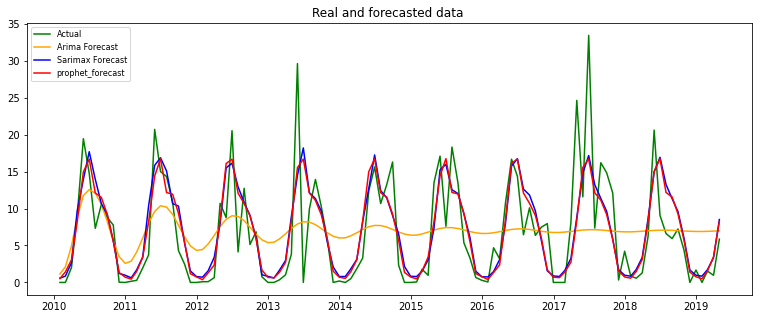

In [42]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

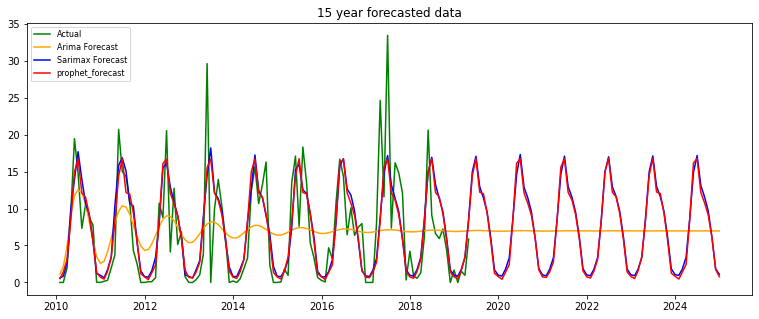

In [43]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+68)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+68)
forecast_10_prophet=full_forecast_prophet['2010-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

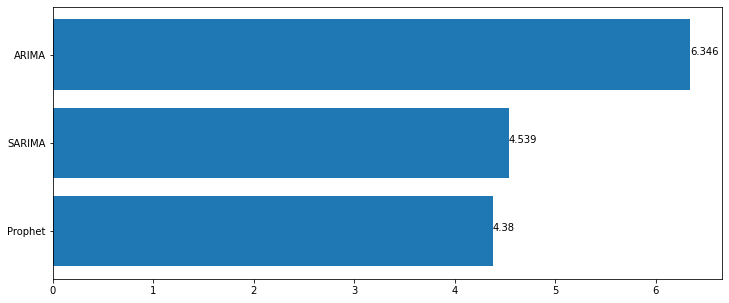

In [44]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)
 
for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))
 
plt.show()

In [45]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--
Enter a date in yyyy-mm-dd format :2023-03-31

Great! Now choose the model result you want to see for 2023-03-31
 1.Arima 
 2.Sarimax
 3.Prophet
 3
Choosen Model is prophet
In 2023-03-31 rainfall value for Prophet model:  3.4940045596810476


In [46]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Srimangal_monthly_merged.csv")